## Variational AutoEnoder:

1. Understanding - disentagled latent spaces
2. Using classifier - to understand its performance, VAE (detach updates) + Classifier => performance
3. Using VAE+ classifier - to understand its performance

In [0]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
 
from scipy.stats import norm
from sklearn import manifold

plt.style.use('fivethirtyeight')
%matplotlib inline

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )


Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


In [0]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")
  
## Visualize some images in the dataset
def visualizeDataset(X):
  for i,image in enumerate(X):
    cv2.imshow(str(i),image)
    cv2.waitKey()
    cv2.destroyAllWindows()

def plot_loss(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  
def plot_accuracy(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  

## Scatter Plot
def scatterplot(x, y, ax, imageData, zoom):
  images = []
  imageSize = 28
  for i in range(len(x)):
    x0, y0 = x[i], y[i]
    
    # Convert to image
    img = imageData[i]*255.
    img = (img).numpy()
    img = img.astype(np.uint8).reshape([imageSize,imageSize])
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    # Note: OpenCV uses BGR and plt uses RGB
    image = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
    images.append(ax.add_artist(ab))
    
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  
  
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))

def plot_scatter(projection,labels):
    plt.scatter(projection[:,0], projection[:,1],c=[palette[i] for i in labels])

In [0]:
class Params:
  nb_latents = 10
  batch_size = 128
  epochs = 100
  log_interval = 100
  save_interval = 1000

  
torch.manual_seed(5)

## Metrics

In [0]:
### Metrics - Base Class For all Metrics
class Metric:
  def __init__(self):
    pass
  def __call__(self, outputs, target, loss):
    raise NotImplementedError
    
  def reset(self):
    raise NotImplementedError
    
  def value(self):
    raise NotImplementedError
    
  def name(self):
    raise NotImplementedError
    
## Accuracy Metric
class AccumulatedAccuracyMetric(Metric):
  def __init__(self):
      self.correct = 0
      self.total = 0
      
  def __call__(self, outputs, target):
      # Track the accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (target == argmax.squeeze()).float().sum()
      self.correct += accuracy 
      self.total += target.size(0)
      return self.value()
  
  def reset(self):
      self.correct = 0
      self.total = 0

  def value(self):
      return 100 * float(self.correct) / self.total

  def name(self):
      return 'Accuracy'
    
    
## Loss
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

## Dataloader

In [0]:
path = "./vae-classifier/"
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)
## Test TSNE plot for reconstrunction on 1000 test samples
testing_tsne = torch.utils.data.DataLoader(test_dataset,batch_size=len(train_dataset),shuffle=True)
test_data, test_labels = next(iter(testing_tsne))[:10000]


In [0]:
print(f"Total number of train images: {len(train_dataset)}, total number of test images: {len(test_dataset)}, total number of train batches: {len(train_loader)}")

Total number of train images: 60000, total number of test images: 10000, total number of train batches: 469


In [0]:
%ls
import os
os.makedirs("vae-classifier/results")

beta-results/     results/      vae-classifier/    VAE_GAN_decoder_249.pth
latent_space.png  sample_data/  VAE_GAN_D_249.pth  VAE_GAN_encoder_249.pth


## Model

In [0]:
class ConvVAE(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAE, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
    
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = ConvVAE(Params.nb_latents)
if is_cuda:
  model = model.to(device)
  
print(model)

ConvVAE(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_std): Linear(in_features=256, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=256, bias=True)
  (fc3): Linear(in_features=

## Loss Function

In [0]:
### Loss Function
### Loss Function
def loss_function(recon_x, x, mu, logvar,beta=1):
  """
  Reconstruction loss  + KL divergence loss over all elements of the batch
  """
  bce = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), size_average=False)
  
  kld = -0.5* (1+ logvar -mu.pow(2) -  logvar.exp())
  return kld.mean(dim = 0), bce + beta*kld.sum()

In [0]:
import os
os.makedirs("vae-classifier/results")
%ls

results/  sample_data/  vae-classifier/


## Latent Space Visualization

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath="./results"):
  model.eval()
  datapoint = datapoint.to(device)
  if isinstance(model,ConvVAE):
    datapoint = datapoint.unsqueeze(0)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 28, 28))
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      
      recon = model.decode(muc).cpu()
      recons[i, zi] = recon.view(28, 28)

  filename = os.path.join(dirpath, 'traversal_' + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)
  
  


In [0]:
## Load Model state
## Save model
def save_model(model,path):
    
    torch.save(model.state_dict(),path)
    
    
def load_model(model,path):
  model.load_state_dict(torch.load(path))


load_model(model,"./vae-classifier/results/model_state_99.pth")

In [0]:
#!pip install tqdm
!pip install opencv-python


## Compute Laplacian Variance for the blur - cv2

In [0]:
## Import CV
import cv2
import numpy


def laplacian_variance(images):
    return [cv2.Laplacian(image.numpy(), cv2.CV_32F).var() for image in images]


def laplacian_variance_numpy(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]


In [0]:
log_interval = 400
save_interval = 400
testpoint = torch.Tensor(train_loader.dataset[0][0]).to(device)
save_results = "./results/"
def train_epoch(epoch):
  model.train()
  train_losses = RunningAverage()
  for batch_idx, (data, labels) in enumerate(train_loader):
    data = data.to(device)
    labels = labels.to(device)
    batch_size = data.size(0)
    recon_batch, mu, logvar = model(data)
    
    kld, loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
    ## parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
    
    loss /=len(data)
    train_losses.update(loss.item())
    if batch_idx % log_interval == 0:
      print("Epoch {}, batch: {}/{}, loss: {:.2f}".format(
              epoch, batch_idx, len(train_loader), loss))
    
  return train_losses()

In [0]:
## Test Epoch
"""
Test
"""
def test_epoch(epoch):
    model.eval()
    test_loss = RunningAverage()
    
    ## Test reconstruction test
    testpoint = torch.Tensor(test_loader.dataset[0][0]).to(device)
  
    with torch.no_grad():
        for i, (data,labels) in enumerate(test_loader):
            data = data.to(device)
             
            batch_size = data.size(0)
            recon_batch, mu, logvar = model(data)
            
            ## Loss of VAE
            kld, loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            
            test_loss.update(loss.item() / len(data))
            
    return test_loss()

/home/chivukula_manju/yes/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, batch: 0/469, loss: -11185.63
Epoch 0, batch: 400/469, loss: -11298.16
Epoch 1, batch: 0/469, loss: -11267.52
Epoch 1, batch: 400/469, loss: -11227.96
Epoch 2, batch: 0/469, loss: -11326.61
Epoch 2, batch: 400/469, loss: -11165.04
Epoch 3, batch: 0/469, loss: -11360.92
Epoch 3, batch: 400/469, loss: -11202.07
Epoch 4, batch: 0/469, loss: -11215.79
Epoch 4, batch: 400/469, loss: -11148.99
Epoch 5, batch: 0/469, loss: -11297.42
Epoch 5, batch: 400/469, loss: -11143.45
Epoch 6, batch: 0/469, loss: -11193.46
Epoch 6, batch: 400/469, loss: -11238.29
Epoch 7, batch: 0/469, loss: -11163.70
Epoch 7, batch: 400/469, loss: -11278.06
Epoch 8, batch: 0/469, loss: -11306.77
Epoch 8, batch: 400/469, loss: -11321.87
Epoch 9, batch: 0/469, loss: -11192.15
Epoch 9, batch: 400/469, loss: -11207.91
Epoch 10, batch: 0/469, loss: -11279.09
Epoch 10, batch: 400/469, loss: -11185.44
Epoch 11, batch: 0/469, loss: -11338.42
Epoch 11, batch: 400/469, loss: -11197.82
Epoch 12, batch: 0/469, loss: -11444

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


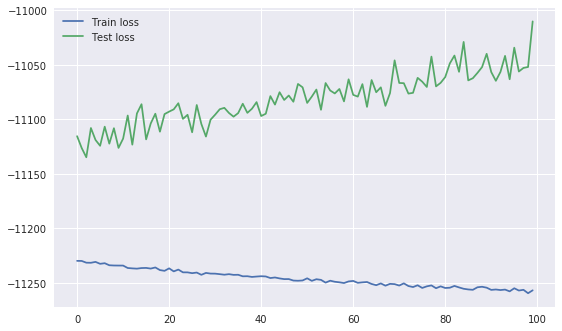

In [0]:
train_losses = []
test_losses = []
for epoch in range(Params.epochs):
  train_loss = train_epoch(epoch)
  train_losses.append(train_loss)
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, Params.epochs, train_loss)
  test_loss = test_epoch(epoch)
  message = 'Epoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, Params.epochs, test_loss)
  test_losses.append(test_loss)
    
plt.plot(range(Params.epochs),train_losses)
plt.plot(range(Params.epochs),test_losses)
plt.legend(["Train loss","Test loss"])
plt.show()

## Reconstructions

In [0]:
def reconstruction(data,epoch, is_train = True):
    save_dir = "vae-classifier/results/"
    n = min(data.size(0), 8)
    recon_batch, mu, logvar = model(data)
    comparison = torch.cat([data[:n],recon_batch[:n]])
    if is_train:
        name = save_dir + "train_reconstruction_" + str(epoch) + '.png' 
    else:
        name = save_dir + "test_reconstruction_" + str(epoch) + '.png' 
    save_image(comparison.cpu(),name, nrow=n)

    
train_batch, train_label = next(iter(train_loader))
test_batch, test_label = next(iter(test_loader))
reconstruction(train_batch.to(device), 100, True)
reconstruction(test_batch.to(device), 100, False)

In [0]:
%pwd

'/home/chivukula_manju/vae'

### Train Reconstruction

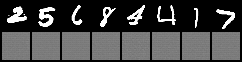

In [0]:
from IPython.display import Image
Image(filename='./vae-classifier/results/train_reconstruction_100.png') 

### Test Reconstruction

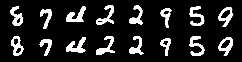

In [0]:
Image(filename='./vae-classifier/results/test_reconstruction_100.png') 

## Generated Samples

In [0]:
epoch = 100
with torch.no_grad():
    sample = torch.randn(64, Params.nb_latents).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 1, 28, 28),
             './vae-classifier/results/sample_' + str(epoch) + '.png')  
  

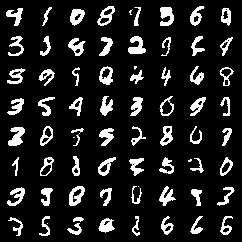

In [0]:
from IPython.display import Image
Image(filename='./vae-classifier/results/sample_100.png') 

## Latent Traversals

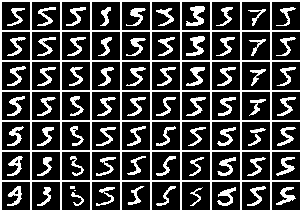

In [0]:
Image(filename='./vae-classifier/results/traversal_99_468.png') 

## TSNE Plot

In [0]:
path = 'latent_space.png'
def visualize_tsne(X, labels, model, path):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    X_encoded, _ = model.encode(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    fig, ax = plt.subplots()
   
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap=plt.cm.get_cmap("viridis", 10))
    plt.colorbar(ticks=range(10))
    fig.savefig(path, dpi=fig.dpi)
    
#visualize_tsne(test_data[:5000].to(device),test_labels[:5000],model,path)


## Loss Plot

In [0]:
plt.plot(range(Params.epochs),train_losses)
plt.plot(range(Params.epochs),test_losses)
plt.legend(["Train loss","Test loss"])
plt.show()
save_model(model,epoch)

## Load model

In [0]:
load_model(model,"./vae-classifier/results/model_state_99.pth")

In [0]:
x_test, y_test = test_data[:2000], test_labels[:2000]
laplacian_variances = [laplacian_variance(x_test[y_test == i]) for i in range(10)]

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


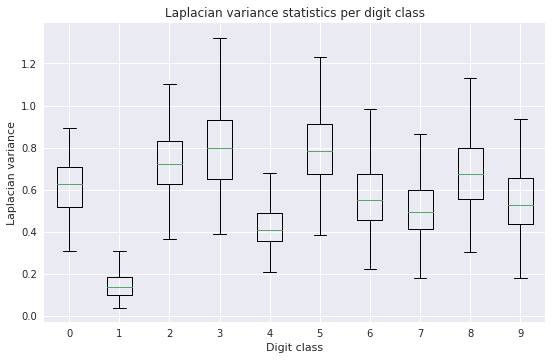

In [0]:
plt.boxplot(laplacian_variances, labels=range(10));
plt.xlabel('Digit class')
plt.ylabel('Laplacian variance')
plt.title('Laplacian variance statistics per digit class');

In [0]:
not_ones = y_test != 1
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
with torch.no_grad():
    reconstructions = np.empty(shape=(len(x_test_not_ones),1,28,28))
    indx = 0
    for i, (x,y) in enumerate(zip(x_test_not_ones,y_test_not_ones)):
        if y != 1:
            recon_batch, mu, logvar = model(x.unsqueeze(1).to(device))
            reconstructions[indx]=(recon_batch.squeeze(0).detach().cpu())
            indx+=1
       

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


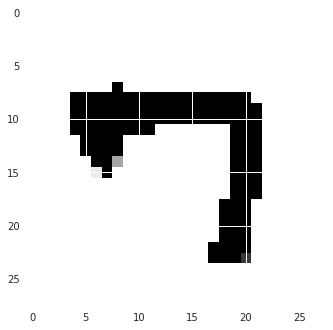

In [0]:
plt.imshow(np.array(reconstructions)[1].squeeze())

In [0]:
laplacian_variances_recons = [laplacian_variance_numpy(np.array(reconstructions[y_test == i], dtype=np.uint8)) 
                              for i in range(10)]

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


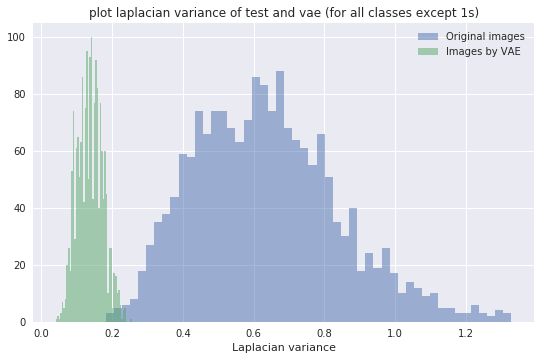

In [0]:
not_ones = y_test != 1

lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance_numpy(np.array(reconstructions, dtype=np.uint8))
def plot_laplacian_variances(lvs_1, lvs_2, title):
    plt.hist(lvs_1, bins=50, alpha=0.5 , label='Original images');
    plt.hist(lvs_2, bins=50, alpha= 0.5 , label='Images by VAE');
    plt.xlabel('Laplacian variance')
    plt.title(title)
    plt.legend();
    


The Laplacian variance increases with increased focus of an image or decreases with increased blur.Furthermore, images with a smaller amount of edges tend to have a smaller Laplacian variance (the Laplacian kernel is often used for edge detection in images). Therefore we first have to analyze the Laplacian variances for digit classes 0-9 in the MNIST test set before we can compare blur differences in generated images:

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


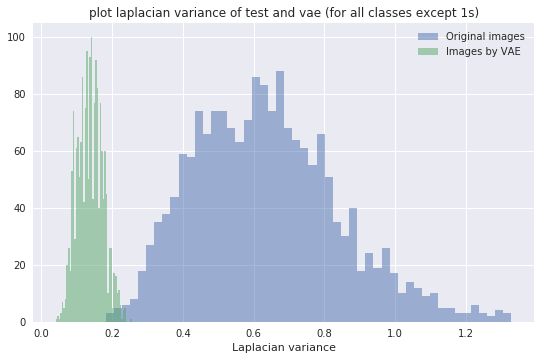

In [0]:
plot_laplacian_variances(lvs_1, lvs_2, "plot laplacian variance of test and vae (for all classes except 1s)")

## Model 2


- VAE is detached
- Test Classifier

In [0]:

torch.manual_seed(5)

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    
    ## Define NN
    self.fc1 = nn.Linear(10, 10)
    
    
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features

In [0]:
## Training
from tqdm import trange

criterion = nn.CrossEntropyLoss()
classifier = Classifier()
if is_cuda:
  classifier = classifier.to(device)

# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)
print(classifier)

Classifier(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
)


In [0]:
## Train Classifier with pretrained vae
#vae_parameters = list(model.named_parameters())
#for name, param in vae_parameters:
 #   param.requires_grad = False

In [0]:
def train_classifier_epoch(epoch):
  model.train()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(train_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    
    recon_batch, mu, logvar = model(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    classifier_loss.backward()
    optimizer.step()
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric
 

In [0]:
## Test Epoch
"""
Test, classifier on learnt features
"""
def test_classifier_epoch(epoch):
  classifier.eval()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(test_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    
    recon_batch, mu, logvar = model(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric

In [0]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = 50
for epoch in range(1, n_epochs):
  
  # Train stage
  train_loss, metric = train_classifier_epoch(epoch)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'
    .format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'
    .format(metric.name(), metric.value())
  print(message)
  
  val_loss, metrics = test_classifier_epoch(epoch)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'
    .format(epoch + 1, n_epochs,val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'
    .format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/50. Train set: Average loss: 0.0122	 Average Accuracy: 	Accuracy: 56.77333333333333
Epoch: 2/50. Train set: Average loss: 0.0122	 Average Accuracy: 	Accuracy: 56.77333333333333
Epoch: 2/50. Test set: Average loss: 0.0077	 Average Accuracy: 	Accuracy: 87.38
Epoch: 3/50. Train set: Average loss: 0.0053	 Average Accuracy: 	Accuracy: 90.18166666666667
Epoch: 3/50. Train set: Average loss: 0.0053	 Average Accuracy: 	Accuracy: 90.18166666666667
Epoch: 3/50. Test set: Average loss: 0.0045	 Average Accuracy: 	Accuracy: 92.66
Epoch: 4/50. Train set: Average loss: 0.0034	 Average Accuracy: 	Accuracy: 93.075
Epoch: 4/50. Train set: Average loss: 0.0034	 Average Accuracy: 	Accuracy: 93.075
Epoch: 4/50. Test set: Average loss: 0.0033	 Average Accuracy: 	Accuracy: 93.87
Epoch: 5/50. Train set: Average loss: 0.0026	 Average Accuracy: 	Accuracy: 94.095
Epoch: 5/50. Train set: Average loss: 0.0026	 Average Accuracy: 	Accuracy: 94.095
Epoch: 5/50. Test set: Average loss: 0.0026	 Average Accurac

### Save Classifier

In [0]:
path ="classifier_model_state_"+str(epoch)+".pth"  
torch.save(classifier.state_dict(),path)

In [0]:
path ="classifier_model_state_"+str(49)+".pth"  
load_model(classifier, path)

## Plots

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


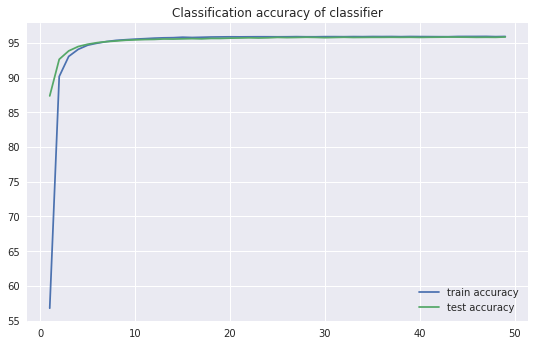

In [0]:
plt.plot(range(1,n_epochs),train_accuracy)
plt.plot(range(1,n_epochs),test_accuracy)
plt.title("Classification accuracy of classifier")
plt.legend(["train accuracy","test accuracy"])

/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


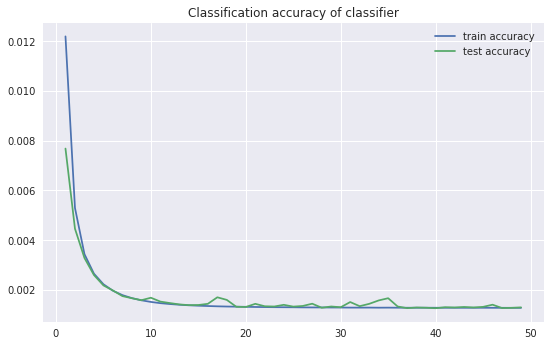

In [0]:
plt.plot(range(1,n_epochs),train_losses)
plt.plot(range(1,n_epochs),test_losses)
plt.title("Classification loss of classifier")
plt.legend(["train accuracy","test accuracy"])

Computing latent space projection...


/home/chivukula_manju/yes/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


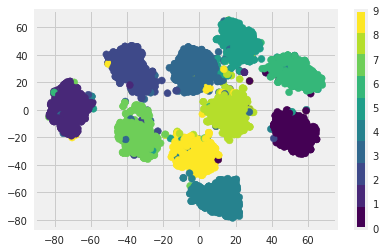

In [0]:
path = "tsne_vae+classifier_trained.png"
visualize_tsne(test_data[:5000].to(device),test_labels[:5000],model,path)


## Model 3
Train with:
VAE + Classifier

In [0]:
classifier = Classifier()
model = ConvVAE(Params.nb_latents)

if is_cuda:
  classifier = classifier.to(device)
  model  = model.cuda()

## VAE is trained
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()) 
                    + list(classifier.parameters()), lr=1e-3)

"""
Train VAE + but not classifier
"""
def train_classifier_all(epoch):

  model.train()
  classifier.train()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(train_loader):
    
    data = data.to(device)
    labels = labels.to(device)
    
    recon_batch, mu, logvar = model(data)
    kld, loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
    
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss =  criterion(outputs, labels)
    
    ## Add all losses.
    loss = loss + classifier_loss
    
    ## parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss /=len(data)
    
    losses.update(loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric



## Test Epoch
"""
Test, classifier on learnt features
"""
def test_with_all_training(epoch):
  classifier.eval()
  model.eval()
  metric = AccumulatedAccuracyMetric()
  #losses = RunningAverage()
  for idx, (data, labels) in enumerate(test_loader):
    
    data, labels = data.to(device), labels.to(device)
    
    recon_batch, mu, logvar = model(data)
    
    ## classifier, pass latent vector
    outputs = classifier(mu)
    
    metric(outputs, labels)
    
    
  return 0.0, metric



In [0]:
import warnings

warnings.filterwarnings("ignore")
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = 50
for epoch in range(1, n_epochs):
  
  # Train stage
  train_loss, metric = train_classifier_all(epoch)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'
    .format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'
    .format(metric.name(), metric.value())
  print(message)
  
  val_loss, metrics = test_with_all_training(epoch)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'
    .format(epoch + 1, n_epochs, val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'
    .format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/50. Train set: Average loss: -7092.0972	 Average Accuracy: 	Accuracy: 26.285
Epoch: 2/50. Train set: Average loss: -7092.0972	 Average Accuracy: 	Accuracy: 26.285
Epoch: 2/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 46.78
Epoch: 3/50. Train set: Average loss: -8804.5527	 Average Accuracy: 	Accuracy: 63.26833333333333
Epoch: 3/50. Train set: Average loss: -8804.5527	 Average Accuracy: 	Accuracy: 63.26833333333333
Epoch: 3/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 73.54
Epoch: 4/50. Train set: Average loss: -9690.9590	 Average Accuracy: 	Accuracy: 78.39166666666667
Epoch: 4/50. Train set: Average loss: -9690.9590	 Average Accuracy: 	Accuracy: 78.39166666666667
Epoch: 4/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 83.35
Epoch: 5/50. Train set: Average loss: -10132.9014	 Average Accuracy: 	Accuracy: 84.31
Epoch: 5/50. Train set: Average loss: -10132.9014	 Average Accuracy: 	Accuracy: 84.31
Epoch: 5/50. Test set: Avera

In [0]:

plt.plot(range(1,n_epochs),train_losses)
plt.plot(range(1,n_epochs),test_losses)
plt.title("Classification loss of classifier")
plt.legend(["train loss","test loss"])

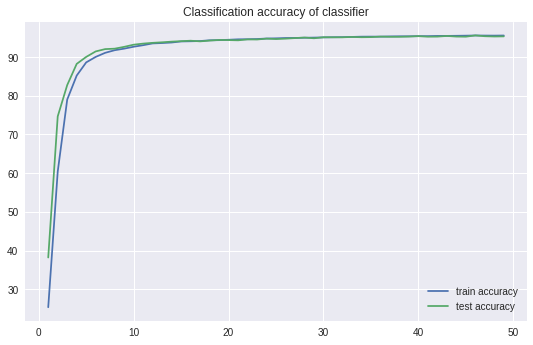

In [0]:
plt.style.use("seaborn")
plt.plot(range(1,n_epochs),train_accuracy)
plt.plot(range(1,n_epochs),test_accuracy)
plt.title("Classification accuracy of classifier")
plt.legend(["train accuracy","test accuracy"])

Computing latent space projection...


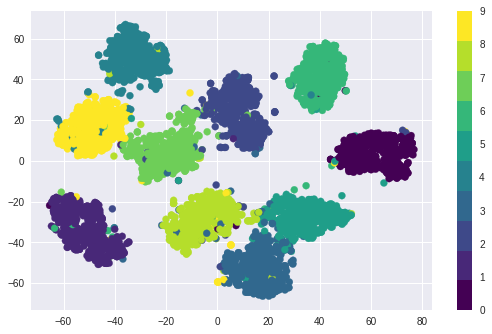

In [0]:
path = "tsne_vae+classifier+vae+train.png"
visualize_tsne(test_data[:5000].to(device),test_labels[:5000],model,path)